In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
from hyperbolicity.delta import compute_exact_hyperbolicity_naive
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from hyperbolicity.tree_fitting_methods.hyperbolicity_learning import train_distance_matrix
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
from hyperbolicity.utils import construct_weighted_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ

In [ ]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

# Display dataset information
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"Shape of data: {iris.data.shape}")

In [30]:
import pickle

# Path to the .pkl file
file_path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_zeisel.pkl'

# Load the .pkl file
with open(file_path, 'rb') as file:
    D_wiki = pickle.load(file)

print("Data loaded successfully.")

Data loaded successfully.


In [31]:
D_wiki.max(), D_wiki.min(), D_wiki.mean(), D_wiki.std()

(0.8762489200150506, 0.0, 0.39649608337634396, 0.14054541733935166)

In [32]:
D_wiki.dtype

dtype('float64')

In [33]:
D_wiki.shape[0]

3005

In [34]:
import time

start_time = time.time()
G = NJ(D_wiki)
end_time = time.time()

print(f"Time to execute: {end_time - start_time:.2f} seconds")

Time to execute: 207.91 seconds


In [ ]:
dist_matrix = nx.floyd_warshall_numpy(G)

In [6]:
# Compute distortion
n= D_wiki.shape[0]
distortion = np.abs(dist_matrix[:n, :n] - D_wiki).max()
print(f"Distortion: {distortion}")

denom = n*(n-1)
l1_norm = np.abs(dist_matrix[:n, :n] - D_wiki).sum()/denom
print(f"L1 Norm: {l1_norm}")

Distortion: 0.7186884500287276
L1 Norm: 0.028711913895433358


Processing file: /share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_csphd_2025-05-01_08-51-51/lr_0.1_dr_0.01_sd_1.0_epoch_1000_batch_32_n_batches_100.pt
Variance of Log-Normal Distribution for: 12.07734


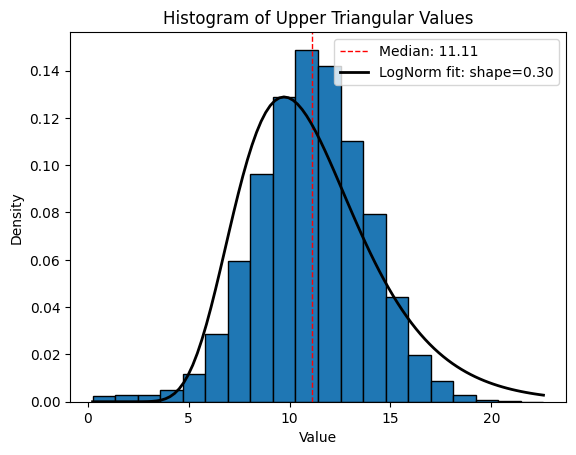

Mean Squared Error (MSE) with Log-Normal for: 0.00030


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import os
import torch

    # Directory containing .pt files
file_path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_csphd_2025-05-01_08-51-51/lr_0.1_dr_0.01_sd_1.0_epoch_1000_batch_32_n_batches_100.pt'

# Iterate over all .pt files in the directory

print(f"Processing file: {file_path}")

# Load the .pt file
data = torch.load(file_path)['weights']
upper_triangular = data.numpy()

"""              # Extract upper triangular values
upper_triangular = data[np.triu_indices(data.shape[0], k=0)]
upper_triangular = upper_triangular[upper_triangular > 0]  # Log-normal requires positive values """

# Plot histogram
plt.hist(upper_triangular, bins=20, edgecolor='black', density=True)
plt.title(f"Histogram of Upper Triangular Values")
plt.xlabel("Value")
plt.ylabel("Density")

# Fit log-normal: returns shape (s), loc, scale such that:
# pdf(x) = lognorm.pdf(x, s, loc=loc, scale=scale)
shape, loc, scale = lognorm.fit(upper_triangular, floc=0)  # force loc=0 is often safer

# Plot vertical line at median (not mean!)
median = np.median(upper_triangular)
plt.axvline(median, color='r', linestyle='dashed', linewidth=1, label=f"Median: {median:.2f}")

# Plot the log-normal PDF
x = np.linspace(min(upper_triangular), max(upper_triangular), 100)
p = lognorm.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2, label=f"LogNorm fit: shape={shape:.2f}")

# Calculate and display the variance of the log-normal distribution
variance = (np.exp(shape**2) - 1) * np.exp(2 * np.log(scale) + shape**2)
print(f"Variance of Log-Normal Distribution for: {variance:.5f}")

plt.legend()
plt.show()

# Compare histogram and log-normal PDF at bin centers
counts, bin_edges = np.histogram(upper_triangular, bins=20, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
lognorm_vals = lognorm.pdf(bin_centers, shape, loc=loc, scale=scale)

mse = np.mean((counts - lognorm_vals) ** 2)
print(f"Mean Squared Error (MSE) with Log-Normal for: {mse:.5f}")


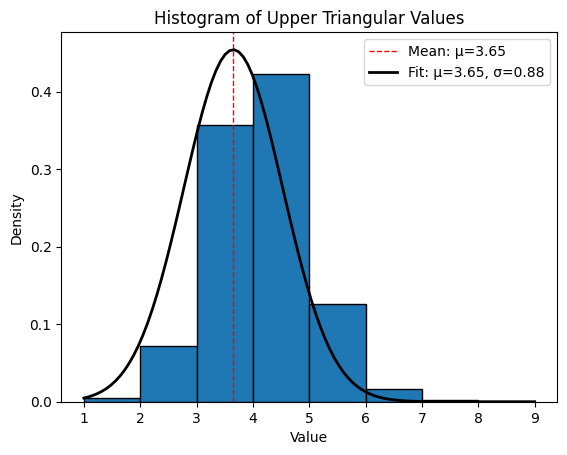

Mean Squared Error (MSE): 0.00599062


In [7]:
from scipy.stats import norm
import pickle
import numpy as np
import matplotlib.pyplot as plt
# Load the .pkl file
file_path_celegan = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_wiki.pkl'
with open(file_path_celegan, 'rb') as file:
    D_celegan = pickle.load(file)

# Extract the upper triangular part of the matrix
upper_triangular = D_celegan[np.triu_indices(D_celegan.shape[0], k=1)]

# Plot histogram with density normalization
plt.hist(upper_triangular, bins=8, edgecolor='black', density=True)
plt.title("Histogram of Upper Triangular Values")
plt.xlabel("Value")
plt.ylabel("Density")



# Fit a Gaussian
mu, std = norm.fit(upper_triangular)

# Plot vertical line at the meanlen(np.unique(data))
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1, label=f"Mean: μ={mu:.2f}")
# Plot the Gaussian PDF
x = np.linspace(min(upper_triangular), max(upper_triangular), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f"Fit: μ={mu:.2f}, σ={std:.2f}")

# Add legend and show
plt.legend()
plt.show()

# Histogram as density
counts, bin_edges = np.histogram(upper_triangular, bins=8, density=True)

# Bin centers
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Gaussian PDF at bin centers
gaussian_vals = norm.pdf(bin_centers, mu, std)

# MSE between histogram density and fitted PDF
mse = np.mean((counts - gaussian_vals) ** 2)
print(f"Mean Squared Error (MSE): {mse:.8f}")

In [39]:
sizes = [15, 15, 15]
probs = [[0.6, 0.15, 0.15],
         [0.15, 0.6, 0.15],
         [0.15, 0.15, 0.6]]
G = nx.stochastic_block_model(sizes, probs)
n = len(G.nodes)
true_labels = np.array([G.nodes[i]['block'] for i in range(n)])
""" n = len(G.nodes)
print(nx.diameter(G))
n = G.number_of_nodes()
G.add_node(n)
for j in range(n+1):
    G.add_weighted_edges_from([(j, n, 100)]) """

dist_matrix = nx.floyd_warshall_numpy(G)

In [49]:
#tree_opt = hdtree(torch.tensor(dist_matrix), 44, 0.1, 1, 44, 100.0, 20, 200, True, True)

In [40]:
best_weights, losses, deltas, errors, duration = train_distance_matrix(torch.tensor(dist_matrix), 10.0, 20.0, 200, 1, 45, 0.1, True, True)
num_nodes = dist_matrix.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
distance_optimized = construct_weighted_matrix(best_weights, num_nodes, edges)

loss = 1.89859, delta = 1.84444, error = 0.00271: 100%|██████████| 200/200 [00:10<00:00, 19.67it/s]


In [42]:
np.abs(distance_optimized-dist_matrix).max()

tensor(0.2787, dtype=torch.float64)

In [41]:
clustering = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='complete').fit(dist_matrix)
labels = clustering.labels_
ari = adjusted_rand_score(true_labels, clustering.labels_)
print('Adjusted Rank Index no optimization', ari)

clustering = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='complete').fit(distance_optimized)
labels = clustering.labels_
ari = adjusted_rand_score(true_labels, clustering.labels_)
print('Adjusted Rank Index optimization', ari)

Adjusted Rank Index no optimization 0.35370406759677736
Adjusted Rank Index optimization 0.8700696055684455


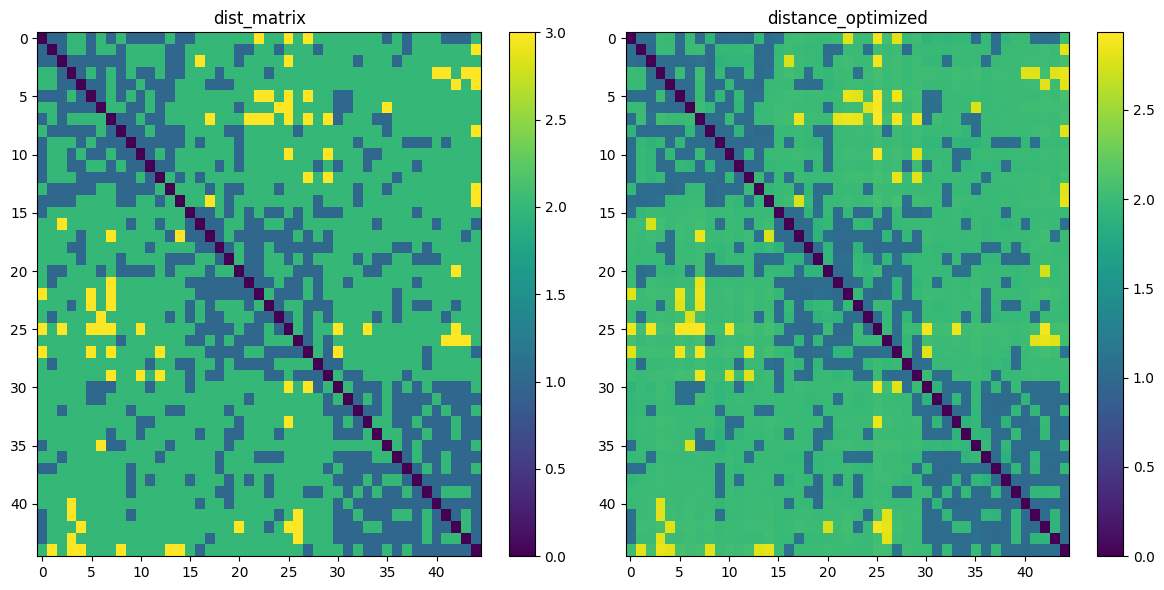

In [52]:
plt.figure(figsize=(12, 6))

# Plot dist_matrix
plt.subplot(1, 2, 1)
plt.title("dist_matrix")
plt.imshow(dist_matrix, aspect='auto')
plt.colorbar()

# Plot distance_optimized
plt.subplot(1, 2, 2)
plt.title("distance_optimized")
plt.imshow(distance_optimized.numpy(), aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

In [195]:
new_row = torch.full((1, distance_optimized.shape[1]), 50)
distance_optimized_node = torch.cat((distance_optimized, new_row), dim=0)
new_column = torch.full((distance_optimized_node.shape[0], 1), 50)
distance_optimized_node = torch.cat((distance_optimized_node, new_column), dim=1)
distance_optimized_node[-1,-1] = 0

In [196]:
tree_opt = gromov_tree(distance_optimized_node.numpy(), num_nodes)

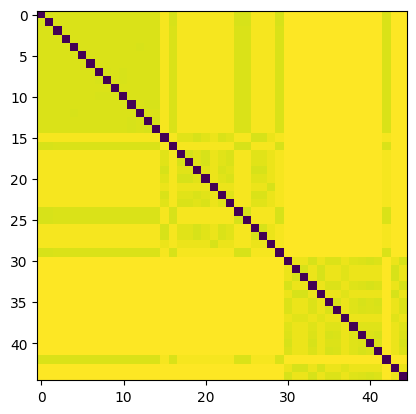

In [197]:
plt.imshow(tree_opt[:-1, :-1])

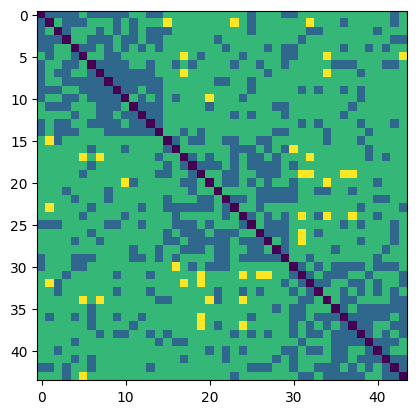

In [198]:
plt.imshow(dist_matrix[:-1, :-1])

In [199]:
Z1 = linkage(dist_matrix, method='ward')
Z2 = linkage(tree_opt[:-1,:-1], method='ward')
cluster_labels1 = fcluster(Z1, t=3, criterion='maxclust') 
cluster_labels2 = fcluster(Z2, t=3, criterion='maxclust') 

def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm) 
    return cm[row_ind, col_ind].sum() / np.sum(cm)

print(clustering_accuracy(true_labels, cluster_labels1))
print(clustering_accuracy(true_labels, cluster_labels2))

0.8444444444444444
0.8888888888888888


/tmp/ipykernel_3910380/428073159.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = linkage(dist_matrix, method='ward')
/tmp/ipykernel_3910380/428073159.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = linkage(tree_opt[:-1,:-1], method='ward')


Adjusted Rank Index no optimization 0.3296575739988392


Adjusted Rank Index optimization 0.5343915343915344
